### trade based simulation

# data import using yfinance

## 라이브러리 임포트

In [76]:
!pip install yfinance
!pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import math
import time
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from collections import deque

In [78]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

## 데이터 임포트

In [79]:
tickers = ["SPY", "QQQ", "GLD", "LQD", "EEM"]
risk_free_asset = "TB3MS"

In [80]:
divs = []
for ticker in tickers:
  div = yf.Ticker(ticker).dividends
  div.index = pd.to_datetime(div.index).strftime('%Y-%m')
  if not div.index.is_unique:
    div = div.groupby(div.index).sum()
  divs.append(div)

In [81]:
dividends_df = pd.concat(divs, axis=1)
dividends_df.columns = [["Dividend"] * len(tickers), tickers]
dividends_df.index.name = "Date"
dividends_df.sort_index(inplace=True)

In [82]:
dividends_df

Dividend                         
             SPY    QQQ GLD    LQD    EEM
Date                                     
1993-03    0.213    NaN NaN    NaN    NaN
1993-06    0.318    NaN NaN    NaN    NaN
1993-09    0.286    NaN NaN    NaN    NaN
1993-12    0.317    NaN NaN    NaN    NaN
1994-03    0.271    NaN NaN    NaN    NaN
...          ...    ...  ..    ...    ...
2022-02      NaN    NaN NaN  0.242    NaN
2022-03    1.366  0.434 NaN  0.256    NaN
2022-04      NaN    NaN NaN  0.255    NaN
2022-05      NaN    NaN NaN  0.254    NaN
2022-06    1.577  0.527 NaN  0.274  0.362

[255 rows x 5 columns]

In [83]:
tickers_df = yf.download(" ".join(tickers), period='max', interval='1mo')

[*********************100%***********************]  5 of 5 completed


In [84]:
tickers_df.index = pd.to_datetime(tickers_df.index).strftime('%Y-%m')

In [85]:
tickers_df.dropna(inplace=True) # drop nan if any
opens_df = tickers_df["Open"]
closes_df = tickers_df["Close"]
# tickers_df.drop(columns=["Adj Close", "High", "Low", "Open", "Volume"], inplace=True)
# tickers_df.dropna(how="all", inplace=True)

In [86]:
closes_df

,EEM,GLD,LQD,QQQ,SPY
Date,,,,,
2004-12,22.427778,43.799999,111.529999,39.919998,120.870003
2005-01,22.308889,42.220001,112.900002,37.400002,118.160004
2005-02,24.468889,43.529999,111.419998,37.220001,120.629997
2005-03,22.533333,42.820000,109.589996,36.570000,117.959999
2005-04,22.252222,43.349998,110.919998,34.980000,115.750000
...,...,...,...,...,...
2022-03,45.150002,180.649994,120.940002,362.540009,451.640015
2022-04,42.380001,176.910004,112.599998,313.250000,412.000000
2022-05,42.639999,171.139999,114.440002,308.279999,412.929993


In [87]:
if not closes_df.index.is_unique:
    closes_df = closes_df.groupby(closes_df.index).last()

In [88]:
tb3ms_df = pdr.DataReader(risk_free_asset, "fred", closes_df.index[0], closes_df.index[-1] )
tb3ms_df["RoR12"] = tb3ms_df[risk_free_asset].map(lambda x: x / 100)
tb3ms_df["CRoR"] = (1 + tb3ms_df["RoR12"] / 12).cumprod()
tb3ms_df.index = pd.to_datetime(tb3ms_df.index).strftime('%Y-%m')

In [89]:
tb3ms_df

,TB3MS,RoR12,CRoR
DATE,,,
2004-12,2.19,0.0219,1.001825
2005-01,2.33,0.0233,1.003770
2005-02,2.54,0.0254,1.005895
2005-03,2.74,0.0274,1.008192
2005-04,2.78,0.0278,1.010527
...,...,...,...
2022-01,0.15,0.0015,1.221228
2022-02,0.33,0.0033,1.221564
2022-03,0.44,0.0044,1.222012


In [90]:
closes_df[risk_free_asset] = tb3ms_df["CRoR"]

In [91]:
closes_df.drop(closes_df.tail(1).index, inplace=True)

In [92]:
closes_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS
Date,,,,,,
2004-12,22.427778,43.799999,111.529999,39.919998,120.870003,1.001825
2005-01,22.308889,42.220001,112.900002,37.400002,118.160004,1.003770
2005-02,24.468889,43.529999,111.419998,37.220001,120.629997,1.005895
2005-03,22.533333,42.820000,109.589996,36.570000,117.959999,1.008192
2005-04,22.252222,43.349998,110.919998,34.980000,115.750000,1.010527
...,...,...,...,...,...,...
2022-01,48.840000,168.089996,127.760002,363.049988,449.910004,1.221228
2022-02,46.730000,178.380005,124.800003,346.799988,436.630005,1.221564
2022-03,45.150002,180.649994,120.940002,362.540009,451.640015,1.222012


# calculate ror and find winners

In [208]:
exclude_period, look_back = 3, 12

In [209]:
ror_df = closes_df.apply(lambda x: round((x.shift(exclude_period) - x.shift(look_back)) / x.shift(look_back), 4), axis=0)

In [210]:
ror_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS
Date,,,,,,
2004-12,NaN,NaN,NaN,NaN,NaN,NaN
2005-01,NaN,NaN,NaN,NaN,NaN,NaN
2005-02,NaN,NaN,NaN,NaN,NaN,NaN
2005-03,NaN,NaN,NaN,NaN,NaN,NaN
2005-04,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-01,-0.0448,-0.0345,-0.0156,0.2275,0.2410,0.0003
2022-02,-0.0910,0.0228,0.0060,0.2536,0.1977,0.0003
2022-03,-0.0842,0.0688,0.0190,0.2467,0.1984,0.0003


In [211]:
winners = ror_df.idxmax(axis=1)

In [212]:
winners[:look_back] = risk_free_asset

In [213]:
winners = winners.to_numpy()

In [214]:
winners

array(['TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS',
       'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'EEM', 'EEM', 'EEM',
       'EEM', 'EEM', 'EEM', 'EEM', 'GLD', 'GLD', 'GLD', 'GLD', 'GLD',
       'GLD', 'SPY', 'GLD', 'EEM', 'SPY', 'EEM', 'EEM', 'EEM', 'EEM',
       'EEM', 'EEM', 'EEM', 'EEM', 'EEM', 'EEM', 'EEM', 'GLD', 'GLD',
       'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'TB3MS', 'TB3MS',
       'TB3MS', 'GLD', 'GLD', 'TB3MS', 'TB3MS', 'GLD', 'LQD', 'EEM',
       'EEM', 'EEM', 'EEM', 'EEM', 'EEM', 'EEM', 'QQQ', 'QQQ', 'QQQ',
       'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'GLD', 'QQQ',
       'QQQ', 'QQQ', 'GLD', 'QQQ', 'QQQ', 'GLD', 'GLD', 'GLD', 'GLD',
       'GLD', 'GLD', 'GLD', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ',
       'QQQ', 'QQQ', 'SPY', 'LQD', 'LQD', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'SPY', 'SPY', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ',
       'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ',
       'QQQ', 

In [215]:
masking = np.roll(winners, 1) != winners

In [216]:
buy_tickers = winners[masking]

In [217]:
buy_tickers

array(['TB3MS', 'EEM', 'GLD', 'SPY', 'GLD', 'EEM', 'SPY', 'EEM', 'GLD',
       'TB3MS', 'GLD', 'TB3MS', 'GLD', 'LQD', 'EEM', 'QQQ', 'GLD', 'QQQ',
       'GLD', 'QQQ', 'GLD', 'QQQ', 'SPY', 'LQD', 'SPY', 'QQQ', 'TB3MS',
       'QQQ', 'TB3MS', 'GLD', 'EEM', 'SPY', 'QQQ', 'EEM', 'QQQ', 'EEM',
       'QQQ', 'TB3MS', 'QQQ', 'SPY', 'QQQ', 'GLD', 'QQQ', 'GLD', 'QQQ',
       'EEM', 'SPY', 'EEM', 'SPY', 'QQQ', 'SPY', 'QQQ', 'SPY'],
      dtype=object)

In [218]:
buy_indices = np.where(masking)[0]

In [219]:
buy_indices, len(buy_indices)

(array([  0,  12,  19,  25,  26,  27,  28,  29,  40,  49,  52,  54,  56,
         57,  58,  65,  68,  76,  79,  80,  82,  89,  97,  98, 100, 108,
        131, 133, 136, 137, 145, 147, 148, 155, 161, 162, 163, 169, 172,
        173, 174, 176, 180, 184, 188, 196, 199, 200, 201, 202, 204, 206,
        208]), 53)

# transaction history (accessing df)

In [220]:
stamp = time.time()
holdings = deque([])
transactions = []
for ticker, index in zip(buy_tickers, buy_indices):
  date_ = closes_df.index[index]
  price_ = closes_df[ticker][index]
  new_buy = {"ticker": ticker, "buy_date": date_, "buy_price": price_}
  if len(holdings):
    # pop existing one
    new_sell = holdings.popleft()
    new_sell["sell_date"] = date_
    new_sell["sell_price"] = closes_df[new_sell["ticker"]][index]
    new_sell["ror"] = (new_sell["sell_price"] - new_sell["buy_price"]) / new_sell["buy_price"] + 1
    transactions.append(new_sell)
  # add new ticker
  holdings.append(new_buy)
print(time.time()-stamp)

0.0022017955780029297


In [221]:
len(transactions), np.prod(list(map(lambda x: x["ror"], transactions)))

(52, 4.77234479531734)

# transactions history (itertuples)

In [222]:
stamp = time.time()
holdings = deque([])
transactions = []
for row, ticker in zip(closes_df[masking].itertuples(), buy_tickers):
  new_buy = {"ticker": ticker, "buy_date": row.Index, "buy_price": getattr(row, ticker)}
  if len(holdings):
    # pop existing one
    new_sell = holdings.popleft()
    new_sell["sell_date"] = row.Index
    new_sell["sell_price"] = getattr(row, new_sell["ticker"])
    new_sell["ror"] = (new_sell["sell_price"] - new_sell["buy_price"]) / new_sell["buy_price"] + 1
    transactions.append(new_sell)
  # add new ticker
  holdings.append(new_buy)
print(time.time()-stamp)

0.0028357505798339844


In [223]:
len(transactions), np.prod(list(map(lambda x: x["ror"], transactions)))

(52, 4.77234479531734)

In [224]:
# transactions

In [225]:
holding = holdings.pop()
holding["up_to_date"] = closes_df.index[-1]
holding["current_price"] = closes_df[holding["ticker"]][-1]
holding["ror"] = (holding["current_price"] - holding["buy_price"]) / holding["buy_price"] + 1
transactions.append(holding)

In [226]:
# transactions

In [227]:
len(transactions), np.prod(list(map(lambda x: x["ror"], transactions)))

(53, 4.783117236351194)

# normalized closes

In [228]:
mrr_df = closes_df.apply(lambda x: round((x.shift(-1) - x) / x, 6) + 1, axis=0)

In [229]:
mrr_df.drop(mrr_df.tail(1).index, inplace=True)

In [230]:
mrr_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS
Date,,,,,,
2004-12,0.994699,0.963927,1.012284,0.936874,0.977579,1.001942
2005-01,1.096822,1.031028,0.986891,0.995187,1.020904,1.002117
2005-02,0.920897,0.983689,0.983576,0.982536,0.977866,1.002283
2005-03,0.987525,1.012377,1.012136,0.956522,0.981265,1.002317
2005-04,1.031607,0.960784,1.002344,1.088622,1.032225,1.002367
...,...,...,...,...,...,...
2021-12,0.999795,0.983212,0.964081,0.912530,0.947259,1.000125
2022-01,0.956798,1.061217,0.976832,0.955240,0.970483,1.000275
2022-02,0.966189,1.012726,0.969071,1.045386,1.034377,1.000367


In [231]:
idx, cols = pd.factorize(winners[:-1])
winner_mrr = mrr_df.reindex(cols, axis=1).to_numpy()[np.arange(len(idx)), idx]

In [232]:
accum_df = mrr_df.apply(lambda x: x.cumprod())

In [233]:
accum_df["RELMOM"] = winner_mrr.cumprod()

In [234]:
accum_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS,RELMOM
Date,,,,,,,
2004-12,0.994699,0.963927,1.012284,0.936874,0.977579,1.001942,1.001942
2005-01,1.091008,0.993836,0.999014,0.932365,0.998014,1.004063,1.004063
2005-02,1.004706,0.977625,0.982606,0.916082,0.975924,1.006355,1.006355
2005-03,0.992172,0.989725,0.994531,0.876253,0.957640,1.008687,1.008687
2005-04,1.023532,0.950912,0.996862,0.953908,0.988500,1.011075,1.011075
...,...,...,...,...,...,...,...
2021-12,2.177668,3.837678,1.145523,9.094453,3.722266,1.219008,5.444209
2022-01,2.083588,4.072609,1.118983,8.687386,3.612396,1.219343,5.283512
2022-02,2.013140,4.124437,1.084374,9.081671,3.736579,1.219791,5.523310


In [235]:
accum_best = accum_df.iloc[-1].max()

In [236]:
ceiling = (accum_best // 5 + 1) * 5 

In [237]:
start_month = int(accum_df.index[0].split("-")[1])

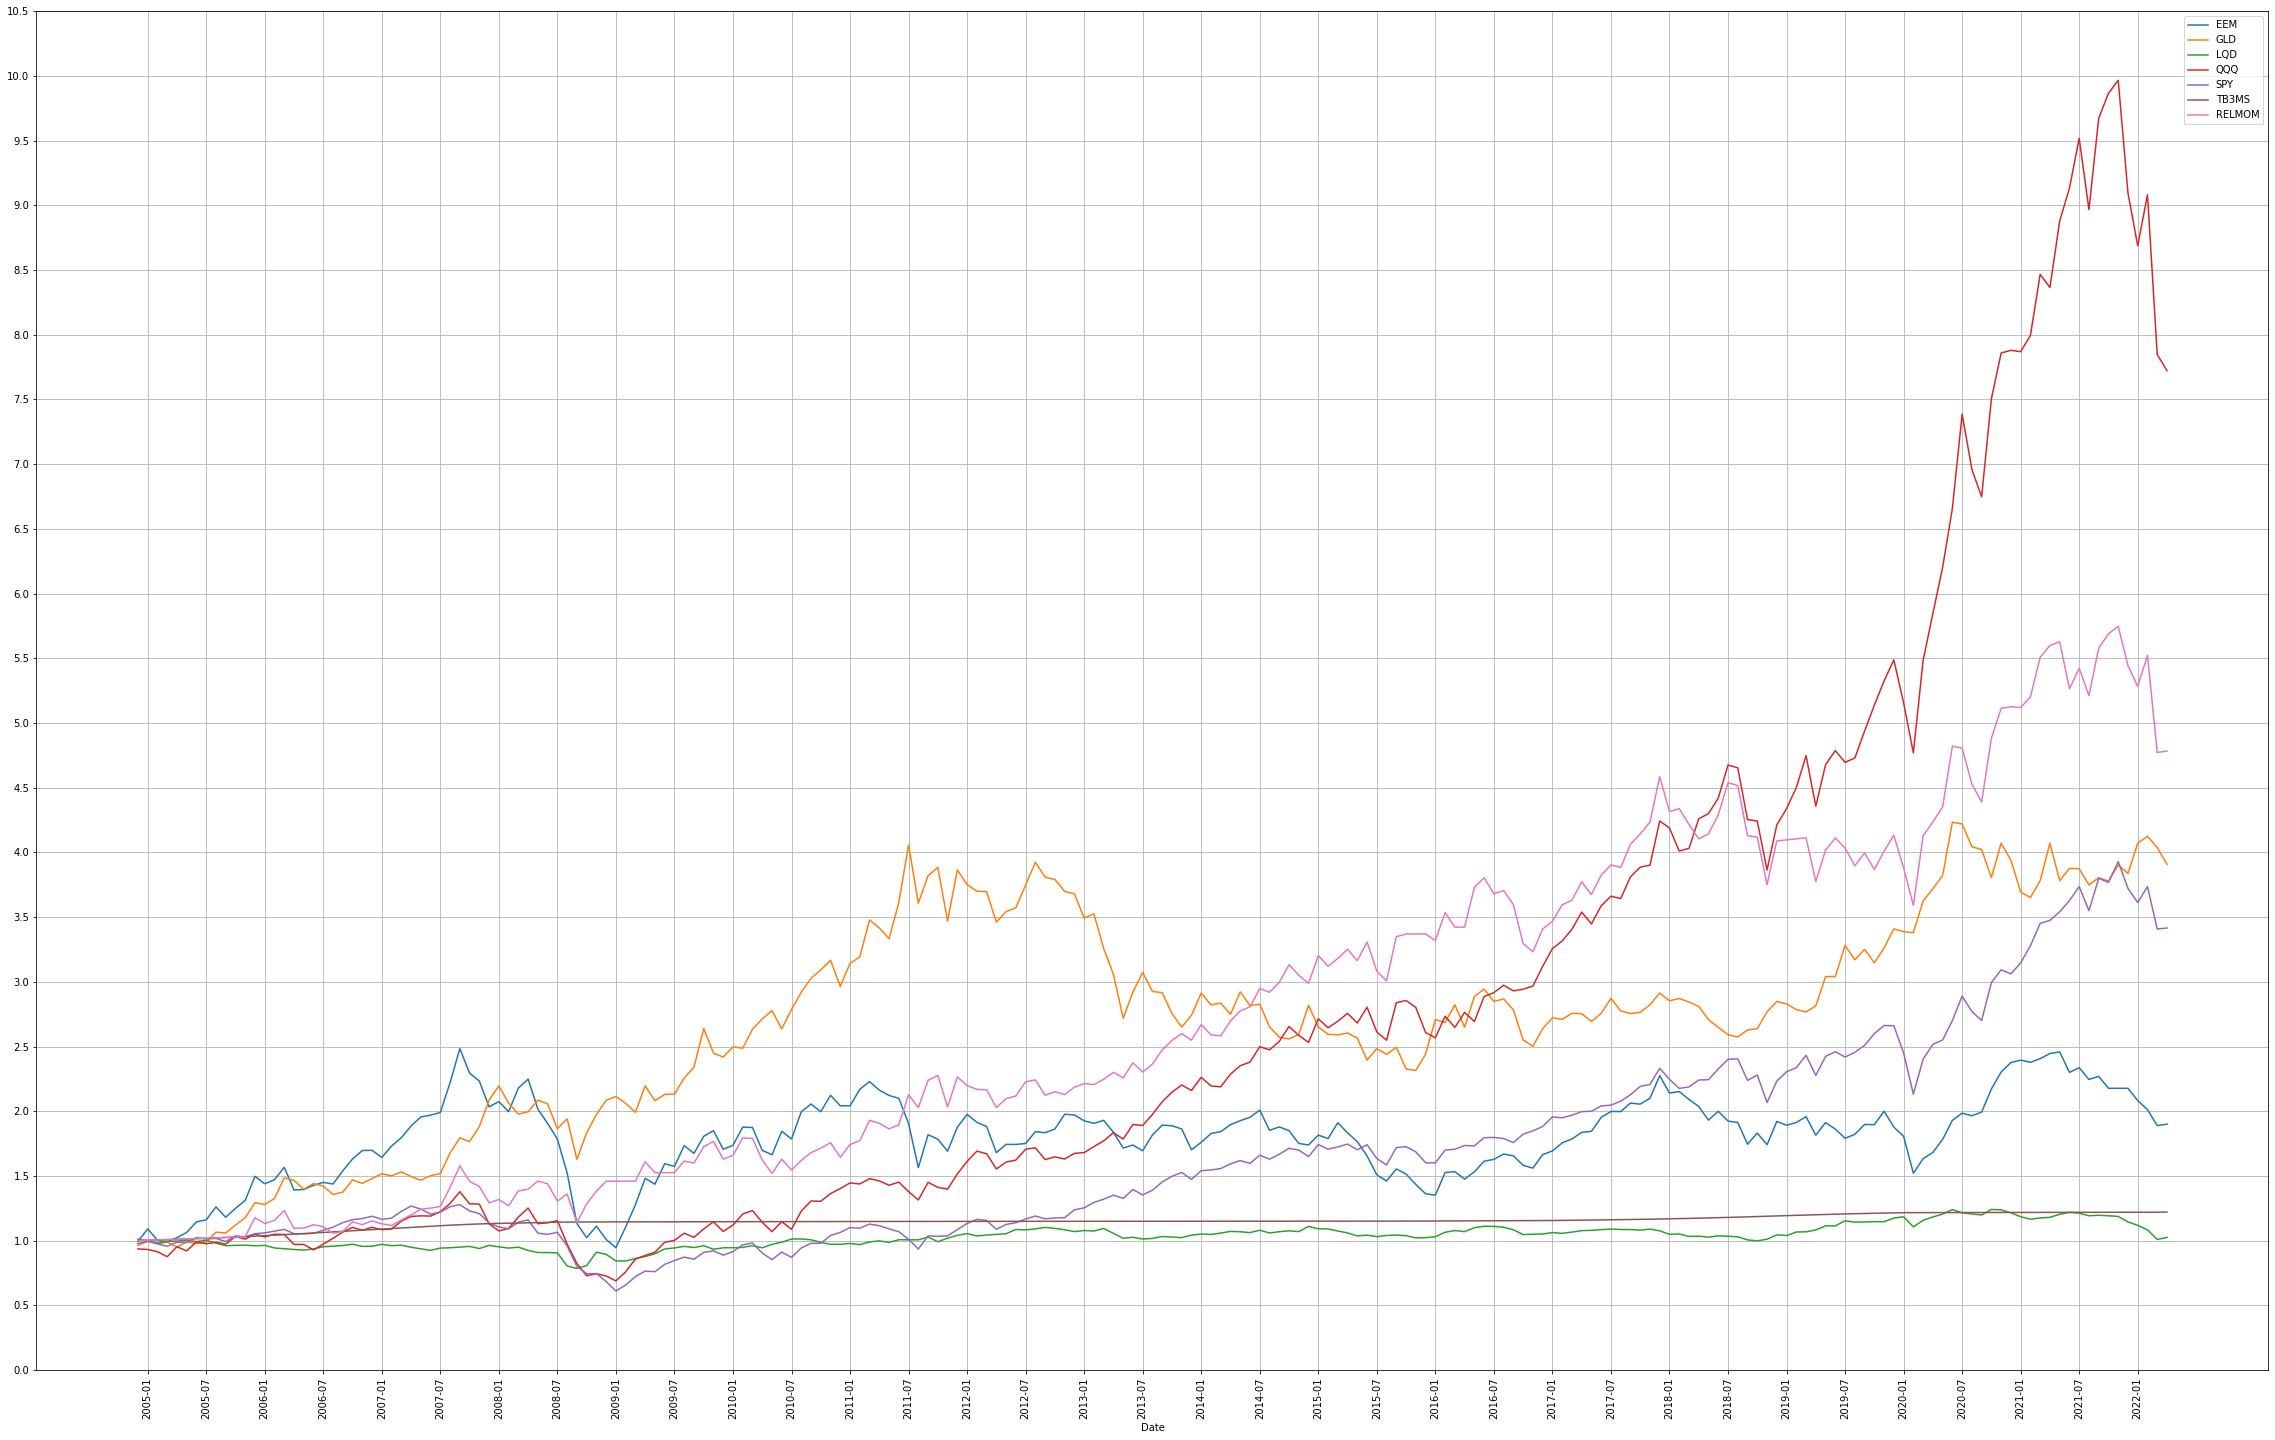

In [238]:
chart = accum_df.plot.line(grid=True, figsize=(40,25), xticks=np.arange((13 - start_month) % 12, len(accum_df.index), 6), yticks=np.arange(0, ceiling + 1, ceiling / 20))
chart.tick_params(axis="x", rotation=90)
# chart.figure.savefig(f'/content/drive/MyDrive/momentum-strategies/absolute_momentum/{current_date}_returns_accum.jpg')